In [0]:
# created by Steve

import os
import pandas as pd
import tweepy
from tweepy import Cursor
import re
import string
import datetime


from textblob import TextBlob

#!pip install tweet-preprocessor
#import preprocessor as p

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('rslp')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [0]:

consumer_key = ""
consumer_secret = ""
access_token = ""
access_secret = ""

#twitter credentials to tweepy
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth)

username = 'iotatoken'
#api.user_timeline(screen_name=username) 
api.get_user(username)

#columns of the csv file
COLS = ['original_text', 'clean_text', 'created_at', 'polarity','subjectivity']

#set two date variables for date range
start_date = '2019-09-18'
end_date = '2019-09-18'

# Happy Emoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

# sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

#Emoji 
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

#combinamos
emoticons = emoticons_happy.union(emoticons_sad)

In [0]:
# declaramos funçoes
def remove_punct(s):
    s = "".join([char for char in s if char not in string.punctuation and char not in emoticons])
    s = re.sub('[0-9]+', '', s)
    return s

def remove_unuseful(s):
    s = re.sub(r'http\S+', '', s)
    s = re.sub('(RT|via)((?:\\b\\W*@\\w+)+)', ' ', s)
    s = re.sub(r'@\S+', '', s)
    s = re.sub('&amp', '', s)
    s = re.sub(r'[^\x00-\x7F]+',' ', s)

    return s
  
def remove_stopwords(text, lang, domain_stopwords=[]):
  
  stop_words = nltk.corpus.stopwords.words(lang) # lang='portuguese' or lang='english'
  
  s = str(text).lower() # tudo para caixa baixa
  table = str.maketrans({key: None for key in string.punctuation})
  s = s.translate(table) # remove pontuacao
  
  tokens = word_tokenize(s) #obtem tokens
  
  v = [i for i in tokens if not i in stop_words and not i in domain_stopwords and not i.isdigit()] # remove stopwords
  s = ""
  for token in v:
    s += token+" "
  return s.strip()

# stemming
def stemming(text,lang):
  
  stemmer = PorterStemmer() # stemming para ingles
  
  if lang=='portuguese':
    stemmer = nltk.stem.RSLPStemmer() # stemming para portuguese
    
  tokens = word_tokenize(text) #obtem tokens
  
  sentence_stem = ''
  doc_text_stems = [stemmer.stem(i) for i in tokens]
  for stem in doc_text_stems:
    sentence_stem += stem+" "
    
  return sentence_stem.strip()


def clean_tweets(text, lang='english', domain_stopwords=[]):
    #text = remove_stopwords(text, lang, domain_stopwords)
    text = remove_unuseful(text)
    text = remove_punct(text)
    text = emoji_pattern.sub(r'', text)
    
    #text = stemming(text, lang)
    tokens = word_tokenize(text)
    
    return ' '.join(tokens)


def get_tweets_(screename, keyword):   
    #page attribute in tweepy.cursor and iteration
    #for page in tweepy.Cursor(api.search, q=keyword, 
    #  count=200, include_rts=False, since=start_date).pages(50):
    tweets = []
    for page in tweepy.Cursor(api.user_timeline, screen_name = screename, \
                              exclude_replies = True, include_rts=False, tweet_mode='extended', cound=200).pages(50):
      for status in page:
            new_entry = []
            status = status._json

            if status['lang'] != 'en':
                continue

            clean_tweet = clean_tweets(status['full_text'])

            #The polarity score is a float within the range [-1.0, 1.0]. 
            #The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.
            blob = TextBlob(clean_tweet)
            Sentiment = blob.sentiment

            polarity = Sentiment.polarity
            subjectivity = Sentiment.subjectivity

            new_entry += [status['full_text'], clean_tweet, status['created_at'],  polarity, subjectivity]

            #single_tweet_df = pd.DataFrame([new_entry], columns=COLS)
            #df = df.append(single_tweet_df, ignore_index=True)
            tweets.append(new_entry)

    #csvFile = open(file, 'a' ,encoding='utf-8')
    #df.to_csv(csvFile, mode='a', columns=COLS, index=False, encoding="utf-8")
    
    return tweets

def get_tweets(userId, limit=50):
  tweets = []
  try:
    tweetsObj = Cursor(
            api.user_timeline, \
            user_id=userId, \
            exclude_replies = True, \
            tweet_mode='extended'
            ).items(limit)
    for cnt, tweet in enumerate(tweetsObj):
      #if not cnt < limit:
      #    break
      # print(tweet.text.replace("\n", ""))
      clean_tweet = clean_tweets(tweet.full_text)

      #pass textBlob method for sentiment calculations
      blob = TextBlob(clean_tweet)
      Sentiment = blob.sentiment

      #seperate polarity and subjectivity in to two variables
      polarity = Sentiment.polarity
      subjectivity = Sentiment.subjectivity
      
      entry = [tweet.full_text, clean_tweet, tweet.created_at, polarity, subjectivity]
      tweets.append(entry)
  except tweepy.error.TweepError as et:
    print(et)

  return tweets 


# keywords
asset_keywords = '#btc OR #bitcoin OR #XBT'
asset_keywords = ''

tweets = get_tweets_(username, asset_keywords)
#tweets = get_tweets(username)
df = pd.DataFrame(tweets, columns=COLS)

df['created_at'] = pd.to_datetime(df["created_at"])

# indexamos 
df['date'] = df["created_at"].apply( lambda df : 
datetime.datetime(year=df.year, month=df.month, day=df.day))	
df.set_index(df["date"],inplace=True)


sentimento = df.resample('D').mean()
#df['polarity'].resample('D', how='mean')

# remplaza valores NaN por cero en dias que nao teve tweets
sentimento.fillna(0, inplace=True)
sentimento.head()

,polarity,subjectivity
date,,
2017-07-02,-0.166667,0.066667
2017-07-03,0.000000,0.000000
2017-07-04,0.214286,0.642857
2017-07-05,0.000000,0.000000
2017-07-06,0.000000,0.000000


**Visualizamos**

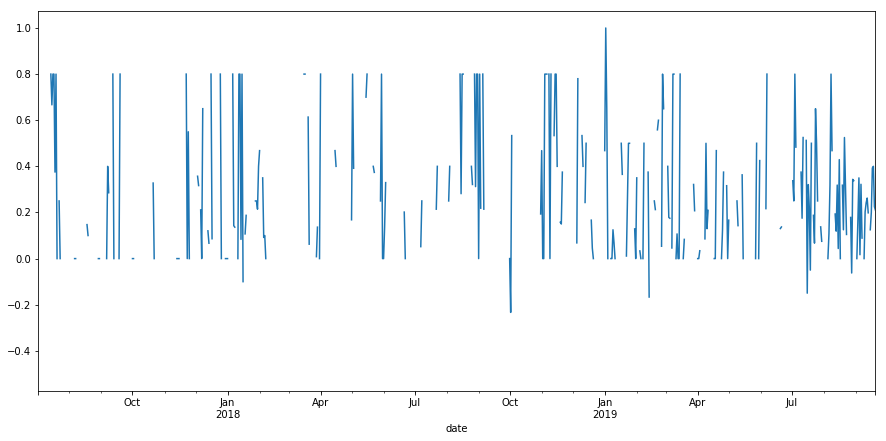

In [0]:
fig, ax = plt.subplots(figsize=(15,7))
#df.groupby(['date']).mean()['polarity'].plot(ax=ax)
df.resample('D').mean()['polarity'].plot(ax=ax)
#df.resample('D').mean()['subjectivity'].plot(ax=ax)

In [0]:
# grabamos a .csv
sentimento.to_csv('sentimento_iota.csv', columns=['polarity', 'subjectivity'], index=True, encoding="utf-8")
print("dados salvos ...")


dados salvos ...
